In [1]:
import scanpy as sc
from torch.utils.tensorboard import SummaryWriter

import argparse
import sys
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_undirected, remove_self_loops, add_self_loops
import torch_geometric
from sklearn.neighbors import kneighbors_graph
from center_loss import CenterLoss, MMDLoss

# 因为修改了dataset文件，直接import得到的一直是之前未修改的代码，所以要reload一下，先import，再reload
import dataset
import importlib
importlib.reload(dataset)

import logger
importlib.reload(logger)

from logger import Logger
from dataset import input_dataset
from data_utils import load_fixed_splits, adj_mul, get_gpu_memory_map

import eval
importlib.reload(eval)

from eval import evaluate, eval_acc, eval_rocauc, eval_f1
from parse import parse_method, parser_add_main_args
import time

import warnings
warnings.filterwarnings('ignore')

# NOTE: for consistent data splits, see data_utils.rand_train_test_idx
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

'''
python main.py --dataset deezer-europe --rand_split --metric rocauc --method nodeformer --lr 1e-5 \
--weight_decay 5e-2 --num_layers 2 --num_heads 1 --rb_order 2 --rb_trans sigmoid --lamda 0.01 \
--M 30 --K 10 --use_bn --use_residual --use_gumbel --runs 5 --epochs 1000 --device 0
'''

'\npython main.py --dataset deezer-europe --rand_split --metric rocauc --method nodeformer --lr 1e-5 --weight_decay 5e-2 --num_layers 2 --num_heads 1 --rb_order 2 --rb_trans sigmoid --lamda 0.01 --M 30 --K 10 --use_bn --use_residual --use_gumbel --runs 5 --epochs 1000 --device 0\n'

In [2]:
parser = argparse.ArgumentParser()

from gnns import *
from nodeformer import *
from data_utils import normalize

default_args = {
    'method': 'nodeformer',
    'dataset': 'data',
    'sub_dataset': '',
    'data_dir': '../data/snarepca/', # 标明数据的位置
    'device': 0,
    'seed': 42,
    'epochs': 5000,
    'eval_step': 10,
    'cpu': False,
    'runs': 1,
    'train_prop': 0.99,
    'valid_prop': 0.005,
    'protocol': 'semi',
    'rand_split': True,
    'rand_split_class': False,
    'label_num_per_class': 20,
    'metric': 'acc',
    'knn_num': 5,
    'save_model': True,
    'model_dir': '../model/',
    'hidden_channels': 128,
    'dropout': 0.0,
    'lr': 1e-5,
    'weight_decay': 5e-2,
    'num_layers': 2,
    'num_heads': 1,
    'M': 35,
    'use_gumbel': True,
    'use_residual': True,
    'use_bn': True,
    'use_act': False,
    'use_jk': False,
    'K': 15,
    'tau': 0.25,
    'lamda': 0.4,
    'rb_order': 2,
    'rb_trans': 'sigmoid',
    'batch_size': 3000,
    'hops': 1,
    'cached': False,
    'gat_heads': 2,
    'out_heads': 1,
    'projection_matrix_type': True,
    'lp_alpha': 0.1,
    'gpr_alpha': 0.1,
    'directed': False,
    'jk_type': 'max',
    'num_mlp_layers': 1
}

args = argparse.Namespace(**default_args)
print(args)

##################### 上面都是设置命令行参数 #####################
fix_seed(args.seed)

if args.cpu:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

Namespace(K=15, M=35, batch_size=3000, cached=False, cpu=False, data_dir='../data/snarepca/', dataset='data', device=0, directed=False, dropout=0.0, epochs=5000, eval_step=10, gat_heads=2, gpr_alpha=0.1, hidden_channels=128, hops=1, jk_type='max', knn_num=5, label_num_per_class=20, lamda=0.4, lp_alpha=0.1, lr=1e-05, method='nodeformer', metric='acc', model_dir='../model/', num_heads=1, num_layers=2, num_mlp_layers=1, out_heads=1, projection_matrix_type=True, protocol='semi', rand_split=True, rand_split_class=False, rb_order=2, rb_trans='sigmoid', runs=1, save_model=True, seed=42, sub_dataset='', tau=0.25, train_prop=0.99, use_act=False, use_bn=True, use_gumbel=True, use_jk=False, use_residual=True, valid_prop=0.005, weight_decay=0.05)


In [3]:
%%time
import time

### Load and preprocess data ###
dataset = input_dataset(args.data_dir, args.dataset)

if len(dataset.label.shape) == 1:
    dataset.label = dataset.label.unsqueeze(1) # 若维度为一，则扩展为 (N, 1)张量
dataset.label = dataset.label.to(device)

CPU times: user 15.6 s, sys: 11.4 s, total: 27.1 s
Wall time: 15.4 s


In [4]:
dataset.graph['node_feat'].shape

torch.Size([17630, 18738])

In [5]:
# get the splits for all runs  划分数据集
if args.rand_split:
    split_idx_lst = [dataset.get_idx_split(train_prop=args.train_prop, valid_prop=args.valid_prop)
                     for _ in range(args.runs)]
elif args.rand_split_class:
    split_idx_lst = [dataset.get_idx_split(split_type='class', label_num_per_class=args.label_num_per_class)
                     for _ in range(args.runs)]
elif args.dataset in ['ogbn-proteins', 'ogbn-arxiv', 'ogbn-products', 'amazon2m']:
    split_idx_lst = [dataset.load_fixed_splits()
                     for _ in range(args.runs)]
else:
    split_idx_lst = load_fixed_splits(args.data_dir, dataset, name=args.dataset, protocol=args.protocol)

### Basic information of datasets 基本信息 ###
n = dataset.graph['num_nodes']
e = dataset.graph['edge_index'].shape[1]
# infer the number of classes for non one-hot and one-hot labels
c = max(dataset.label.max().item() + 1, dataset.label.shape[1])
d = dataset.graph['node_feat'].shape[1]

print(f"dataset {args.dataset} | num nodes {n} | num edge {e} | num node feats {d} | num classes {c}")

dataset data | num nodes 17630 | num edge 93035 | num node feats 18738 | num classes 22


In [6]:
# whether or not to symmetrize
train_edge = dataset.graph['edge_index']
if not args.directed and args.dataset != 'ogbn-proteins':
    dataset.graph['edge_index'] = to_undirected(dataset.graph['edge_index']) # 转无向表示

dataset.graph['edge_index'], dataset.graph['node_feat'] = \
    dataset.graph['edge_index'].to(device), dataset.graph['node_feat'].to(device)

### Load method ###
model = parse_method(args, dataset, n, c, d, device)

### center loss ###
center_loss = CenterLoss(num_classes=c, feat_dim=args.hidden_channels, use_gpu=True)

### Loss function (Single-class, Multi-class) ###
if args.dataset in ('yelp-chi', 'deezer-europe', 'twitch-e', 'fb100', 'ogbn-proteins'):
    criterion = nn.BCEWithLogitsLoss() # 二分类
else:
    criterion = nn.NLLLoss() # 多分类，负对数似然

### Performance metric (Acc, AUC, F1) ###
if args.metric == 'rocauc':
    eval_func = eval_rocauc
elif args.metric == 'f1':
    eval_func = eval_f1
else:
    eval_func = eval_acc

logger = Logger(args.runs, args)

model.train()
print('MODEL:', model)

# dataset.graph['edge_index'][0, :] = dataset.graph['edge_index'][0, :].int()
# dataset.graph['edge_index'][1, :] = dataset.graph['edge_index'][1, :].int()

### Adj storage for relational bias ###
adjs = []
adj, _ = remove_self_loops(dataset.graph['edge_index'])
adj, _ = add_self_loops(adj, num_nodes=n)
adjs.append(adj)
for i in range(args.rb_order - 1): # edge_index of high order adjacency
    adj = adj_mul(adj, adj, n)
    adjs.append(adj)
dataset.graph['adjs'] = [adj.to(torch.int).to(torch.int64) for adj in adjs]

## 去掉用于训练的点对中的自环
adj_loss_inter, _ = remove_self_loops(train_edge[:, 0:dataset.n_infer])
adj_loss_intra2, _ = remove_self_loops(train_edge[:, dataset.n_infer_intra1:])

## 用于后面利益data2图内连接
node1_intra = adj_loss_intra2[0]
node2_intra = adj_loss_intra2[1]

# ## 获得内图的邻接矩阵
# adjo, _ = remove_self_loops(dataset.edge)
# adjo, _ = add_self_loops(adjo, num_nodes=n)

# adj_ = np.zeros((n, n))
# for i in range(dataset.edge.size(1)):
#     start_node = int(dataset.edge[0, i])
#     end_node = int(dataset.edge[1, i])
    
#     # 添加边到邻接矩阵
#     adj_[start_node, end_node] = 1
#     adj_[end_node, start_node] = 1


# # adj_ = torch_geometric.utils.to_scipy_sparse_matrix(adjo).todense() 
# intra_ga1 = adj_[0:dataset.n_data1,:][:,0:dataset.n_data1] # data1
# intra_ga2 = adj_[dataset.n_data1:,:][:,dataset.n_data1:] # data2

# 想给graph1也加一个图损失，待修改
# adj_2 = np.zeros((dataset.n_data2, dataset.n_data2))
# intra2_graph = train_edge[:, dataset.n_infer:]
# for i in range(intra2_graph.size(1)):
#     start_node = intra2_graph[0, i] - dataset.n_data1
#     end_node = intra2_graph[1, i] - dataset.n_data1
#     # 添加边到邻接矩阵
#     adj_2[start_node, end_node] = 1
#     adj_2[end_node, start_node] = 1
# adj_2 = torch.from_numpy(adj_2).float().cuda()
# torch.diagonal(adj_2).fill_(1)
# adj_2 = intra_ga2/torch.sum(torch.from_numpy(intra_ga2),1)
# adj_2 = adj_2.cuda()


# ## 除了data1内图外的邻接矩阵，即用于训练的图结构
# adj_all = np.zeros((dataset.n_data2, dataset.n_data2))
# intra2_graph = train_edge[:, dataset.n_infer:]
# for i in range(intra2_graph.size(1)):
#     start_node = int(intra2_graph[0, i] - dataset.n_data1)
#     end_node = int(intra2_graph[1, i] - dataset.n_data1)
#     # 添加边到邻接矩阵
#     adj_all[start_node, end_node] = 1
#     adj_all[end_node, start_node] = 1
# adj_all = torch.from_numpy(adj_all).float().cuda()
# torch.diagonal(adj_all).fill_(1)
# adj_all = intra_ga2/torch.sum(torch.from_numpy(intra_ga2),0)
# adj_all = adj_all.cuda()

def top_k(raw_graph, K):
    values, indices = raw_graph.topk(k=int(K), dim=-1)
    assert torch.max(indices) < raw_graph.shape[1]
    mask = torch.zeros(raw_graph.shape).cuda()
    mask[torch.arange(raw_graph.shape[0]).view(-1, 1), indices] = 1.
    mask.requires_grad = False
    sparse_graph = raw_graph * mask
    return sparse_graph

MODEL: NodeFormer(
  (convs): ModuleList(
    (0-1): 2 x NodeFormerConv(
      (Wk): Linear(in_features=128, out_features=128, bias=True)
      (Wq): Linear(in_features=128, out_features=128, bias=True)
      (Wv): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=18738, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=22, bias=True)
  )
  (bns): ModuleList(
    (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (chonggou): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=18738, bias=True)
  )
)


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def centre2(dataset, z2, outt):
    label1 = dataset.label.squeeze(1)[:dataset.n_data1]
    label2 = torch.argmax(outt[dataset.n_data1:], dim=1)
    n_label = len(torch.unique(dataset.label.squeeze(1)))
    emb_data1 = z2.squeeze(0)[:dataset.n_data1, :]
    emb_data2 = z2.squeeze(0)[dataset.n_data1:, :]
    ctr_data1 = torch.zeros((n_label, emb_data1.shape[1]), dtype=torch.float32, device=z2.device)
    ctr_data2 = torch.zeros((n_label, emb_data2.shape[1]), dtype=torch.float32, device=z2.device)
    for k in range(n_label):
        mask1 = label1 == k
        mask2 = label2 == k
        count1 = torch.sum(mask1, dtype=torch.float32)
        count2 = torch.sum(mask2, dtype=torch.float32)
        ctr_data1[k] = torch.where(mask1.sum() > 0, torch.sum(emb_data1 * mask1[:, None], dim=0) / count1, torch.zeros(emb_data1.shape[1], device=z2.device))
        ctr_data2[k] = torch.where(mask2.sum() > 0, torch.sum(emb_data2 * mask2[:, None], dim=0) / count2, torch.zeros(emb_data2.shape[1], device=z2.device))
        # selected_emb_data2 = emb_data2[mask2]
        # selected_outt = outt[dataset.n_data1:][mask2, k]
        # ctr_data2[k] = torch.where(mask2.sum() > 0, torch.sum(selected_emb_data2 * selected_outt[:, None], dim=0) / count2, torch.zeros(emb_data2.shape[1], device=z2.device))
    return ctr_data1, ctr_data2, n_label


In [8]:
import matplotlib.pyplot as plt
def plot_histogram(data, label, name = "", bin_width=0.1):
    # 将CUDA张量转移到CPU
    values = data[0].cpu()
    categories = data[1].cpu()
    label = label.squeeze().cpu()
    
    # early stop
    # pro = sum(data[0] > 0.8)/dataset.n_data2

    # 初始化计数向量
    count_vector_1 = torch.zeros(int(1 / bin_width)) # 计p的数目
    count_vector_2 = torch.zeros(int(1 / bin_width)) # 计正确的数目

    # 判断索引与对应的类别向量中的值是否相等
    for i in range(len(values)):
        index = int(values[i] / bin_width)
        if index < len(count_vector_1):
            count_vector_1[index] += 1
            if categories[i] == label[i]:
                count_vector_2[index] += 1

    # 绘制直方图
    bins = torch.linspace(0, 1, int(1 / bin_width))
    
    # plt.figure(figsize=(3, 2), dpi=200)
    plt.bar(bins, count_vector_1, width=bin_width, align='edge', color='blue', label='False')
    plt.bar(bins, count_vector_2, width=bin_width, align='edge', color='orange', label='True', alpha=0.7)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title(name)
    plt.legend()
    plt.show()
    # plt.savefig('savefig_example.png')

In [9]:
# model.reset_parameters()

In [10]:
MMD = MMDLoss()
from torch.utils.data import DataLoader, TensorDataset

# 定义 batch size
batch_size = 100

def cosine_sim(x, y):
    x = x / torch.norm(x, dim=1, keepdim=True)
    y = y / torch.norm(y, dim=1, keepdim=True)
    sim = torch.matmul(x, torch.transpose(y, 0, 1))

    return sim

In [ ]:
### Training loop ###
l = 100 # 用于早停
num = 0
query = torch.arange(dataset.n_data1, dataset.n_data1+dataset.n_data2, dtype=torch.int64, device=device)
label_train = dataset.label.squeeze(1).clone()
for run in range(args.runs):
    split_idx = split_idx_lst[run]
    train_idx = split_idx['train'].to(device)
    model.reset_parameters()
    
    params = list(model.parameters()) + list(center_loss.parameters())
    optimizer = torch.optim.Adam(params,weight_decay=args.weight_decay, lr=args.lr)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.2)
    
    best_val = float('-inf')
    best_query = float('-inf')

    for epoch in range(args.epochs):
        
        # scheduler.step()
        
        model.train()
        optimizer.zero_grad()

        
        # out, z1, z2 = model(dataset)
        out, link_loss_, z1, z2, chonggou = model(dataset.graph['node_feat'], dataset.graph['adjs'], args.tau)
        
        
        label1 = dataset.label.squeeze()[0:dataset.n_data1]

        outt = F.log_softmax(out, dim=1)
        p = F.softmax(out, dim=1)
        

        loss = criterion(
            outt[train_idx], label_train[train_idx])
        loss = torch.clamp(loss - 0.0, min=0)
        
        # 计算训练后锚点对间的MSE损失。希望锚点对尽量的接近
        node1_inter = adj_loss_inter[0].int()
        node2_inter = adj_loss_inter[1].int()
        feature1_inter = z2[:,node1_inter, :] ###
        feature2_inter = z2[:,node2_inter, :] ###
        mse_loss_inter = F.mse_loss(feature1_inter, feature2_inter)
        mse_loss_inter = torch.clamp(mse_loss_inter - 0.1, min=0)

        loss += (mse_loss_inter)# + mse_loss_intra

        # # data2图结构的第二种损失，靠邻域的平滑
        # z_data2 = z2.squeeze(0)[dataset.n_data1:, :].double()
        # loss_preg = torch.mean(torch.norm(torch.mm(adj_all, z_data2) - z_data2, p = 2, dim = 1) / 2)
        # loss += torch.clamp(loss_preg - 1, min=0)

        # if args.method == 'nodeformer':
        #     loss -= args.lamda*0.2 * sum(link_loss_) / len(link_loss_)
        
        # data2图内连接损失
        values, indices = torch.max(p, dim=1)
        node1_values = values[node1_intra.int()]
        node2_values = values[node2_intra.int()]
        node1_indices = indices[node1_intra.int()]
        node2_indices = indices[node2_intra.int()]

        a = node1_values * node2_values * (node1_indices == node2_indices).float()
        a[a > 0.01] = 1
        loss_inter2 = 1 - torch.sum(a) / len(a)
        loss += torch.clamp(loss_inter2 - 0.1, min=0)
            
        # print(loss)
        # assert False, print('测试！')
        
        # atac重构损失
        # loss += 1*F.mse_loss(chonggou.squeeze()[dataset.n_data1: , :], dataset.graph['node_feat'][dataset.n_data1: , :])
        
        
        
#         ## MMD损失
#         d1 = z2[: ,0: dataset.n_data1, :].squeeze()
#         d2 = z2[: ,dataset.n_data1: , :].squeeze()
#         # 创建 DataLoader 来分批次加载数据
#         d1_dataset = TensorDataset(d1)
#         d2_dataset = TensorDataset(d2)
#         d1_dataloader = DataLoader(d1_dataset, batch_size=batch_size, shuffle=True)
#         d2_dataloader = DataLoader(d2_dataset, batch_size=batch_size, shuffle=True)
        
#         total_loss = 0.0
#         # sim_loss = 0.0
#         for d1_batch, d2_batch in zip(d1_dataloader, d2_dataloader):
#             source = d1_batch[0]
#             target = d2_batch[0]
#             # 计算当前批次的 MMD 损失
#             total_loss += MMD(source=source, target=target).item()
            
#             # top_k_sim = torch.topk(
#             #     torch.max(cosine_sim(target, source), dim=1)[0],
#             #     int(target.shape[0] * 0.6))
#             # sim_loss += torch.mean(top_k_sim[0])

#         # 计算平均损失
#         average_loss = total_loss / len(d1_dataloader)
#         loss += average_loss
        
        # sim_loss = sim_loss / len(d1_dataloader)
        # loss += 1 - sim_loss
        
#         d1 = z1[: ,0: dataset.n_data1, :].squeeze()
#         d2 = z1[: ,dataset.n_data1: , :].squeeze()
#         # 创建 DataLoader 来分批次加载数据
#         d1_dataset = TensorDataset(d1)
#         d2_dataset = TensorDataset(d2)
#         d1_dataloader = DataLoader(d1_dataset, batch_size=batch_size, shuffle=True)
#         d2_dataloader = DataLoader(d2_dataset, batch_size=batch_size, shuffle=True)
        
#         total_loss = 0.0
#         for d1_batch, d2_batch in zip(d1_dataloader, d2_dataloader):
#             source = d1_batch[0]
#             target = d2_batch[0]
#             # 计算当前批次的 MMD 损失
#             total_loss += MMD(source=source, target=target).item()
#         # 计算平均损失
#         average_loss = total_loss / len(d1_dataloader)
#         loss += average_loss
        
        
        
        
        loss.backward()
        
        # for param in center_loss.parameters():
        #     # lr_cent is learning rate for center loss, e.g. lr_cent = 0.5
        #     param.grad.data *= (0.5 / (alpha * args.lr))
    
        optimizer.step()

        if epoch % args.eval_step == 0:
            result = evaluate(model, dataset, split_idx, eval_func, criterion, args)
            logger.add_result(run, result[:-1])
            
            selected_indices = torch.nonzero(torch.max(p, axis = 1)[0][query] > 0.95).squeeze()

            # 将符合条件的索引从 data2 移动到 data1
            if (selected_indices.numel() and epoch % 50 == 0):
                if query[selected_indices].dim() == 0:
                    query_selected = query[selected_indices].unsqueeze(0)
                else:
                    query_selected = query[selected_indices]
                train_idx = torch.cat((train_idx, query_selected), dim=0)
            
                print("123: ",sum(label_train[query_selected] == torch.max(p, axis=1)[1][query_selected])/(1+int(label_train[query_selected].size(0))))
                print("数目: ", int(label_train[query_selected].size(0)), ". 正确的数目: ", sum(label_train[query_selected] == torch.max(p, axis=1)[1][query_selected]))
            
                label_train[query_selected] = torch.max(p, axis=1)[1][query_selected]

                # 从 data2 的索引中去掉已移动的索引
                mask = torch.ones_like(query, dtype=torch.bool)
                mask[selected_indices] = 0
                # 通过布尔掩码筛选保留的元素
                query = query[mask]

            print(f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * result[0]:.2f}%, '
                  f'Valid: {100 * result[1]:.2f}%, '
                  f'Test: {100 * result[2]:.2f}%, '
                  f'Query: {100 * result[3]:.2f}%')
            
        if epoch % 50 == 0:
            # plt.figure(figsize=(3,2))
            # plot_histogram(torch.max(p[0:dataset.n_data1,:], axis=1), dataset.label[0:dataset.n_data1], name = "reference", bin_width=0.1)    
            plt.figure(figsize=(3,2))
            plot_histogram(torch.max(p[dataset.n_data1:,:], axis=1), dataset.label[dataset.n_data1:], name = "query", bin_width=0.1)
        
        if l > loss:
            l = loss
            query_acc = result[3];
            num = 0
            ## 保存最优结果
            filename = f'../results/{args.dataset}.csv'
            # print(f"Saving results to {filename}")
            torch.save(z2, '../results/embedding.pt')
            torch.save(p, '../results/out.pt')
            torch.save(split_idx_lst, '../results/split_idx_lst.pt')
            torch.save(dataset.label, '../results/label.pt')
            torch.save(dataset.num_celltype, '../results/num_celltype.pt')
            torch.save(dataset.metadata, '../results/metadata.pt')
            torch.save(default_args, '../results/args.pt')
            with open(f"{filename}", 'w') as write_obj:
                write_obj.write(f"{args.method}," +
                                f"epoch: {epoch:02d}," +
                                f"Query: {100 * result[3]:.2f}%")
        else:
            num = num + 1
        
        # pro = sum(torch.max(p[dataset.n_data1:,:], axis=1)[0] > 0.8)/dataset.n_data2
        # print(pro)
        if num >= 50:# or pro > 0.8:
            print (f'Answer Query: {100 * query_acc:.2f}%')
            break;
        
        #if result[1] > best_val:
        # if epoch == 385:
        #         best_val = result[1]
        #         best_query = result[3]
                
        #         os.makedirs(args.model_dir, exist_ok=True)
        #         os.makedirs('../results/', exist_ok=True)
                
        #         if args.save_model:
        #             torch.save(model.state_dict(), args.model_dir + f'{args.dataset}-{args.method}.pkl')
                
        #         ### Save results ###
        #         filename = f'../results/{args.dataset}.csv'
        #         print(f"Saving results to {filename}")
        #         with open(f"{filename}", 'w') as write_obj:
        #             write_obj.write(f"{args.method}," +
        #                             f"epoch: {epoch:02d}," +
        #                             f"Query: {100 * result[3]:.2f}%")
                    
        #         torch.save(z2, '../results/embedding.pt')
        #         torch.save(p, '../results/out.pt')

    logger.print_statistics(run)
    
    
# torch.save(split_idx_lst, '../results/split_idx_lst.pt')
# torch.save(dataset.label, '../results/label.pt')
# torch.save(dataset.num_celltype, '../results/num_celltype.pt')
# torch.save(dataset.metadata, '../results/metadata.pt')
# torch.save(default_args, '../results/args.pt')
results = logger.print_statistics()

# ### Save results ###
# filename = f'results/{args.dataset}.csv'
# print(f"Saving results to {filename}")
# with open(f"{filename}", 'a+') as write_obj:
#     write_obj.write(f"{args.method}," +
#                     f"{best_val.mean():.3f} ± {best_val.std():.3f}," +
#                     f"{best_test.mean():.3f} ± {best_test.std():.3f}\n")

In [ ]:
embedding = torch.load('../results/embedding.pt', map_location=torch.device('cpu'))
embedding = embedding[0].detach().numpy()

label = torch.load('../results/label.pt', map_location=torch.device('cpu')) # 原始的类型
label = label.squeeze().numpy() 

out = torch.load('../results/out.pt', map_location=torch.device('cpu')) # 预测的类型
pre = out.argmax(dim=-1, keepdim=True).detach().squeeze().numpy()
pro = out.max(dim=-1, keepdim=True)[0].detach().squeeze().numpy()

metadata = torch.load('../results/metadata.pt', map_location=torch.device('cpu')) # tech
metadata = metadata.squeeze().numpy() 

num_celltype = torch.load('../results/num_celltype.pt', map_location=torch.device('cpu')) # 数字与类型的对应关系
print(num_celltype)

In [12]:
# 画图
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

embedding = z2.cpu()
embedding = embedding[0].detach().numpy()#

label = dataset.label.cpu() # 原始的类型
label = label.squeeze().numpy() 

metadata = dataset.metadata.cpu()
metadata = metadata.squeeze().numpy() 

out = p.cpu() # 预测的类型
pre = out.argmax(dim=-1, keepdim=True).detach().squeeze().numpy()

num_celltype = dataset.num_celltype # 数字与类型的对应关系
print(num_celltype)

{0: 'Ast', 1: 'Clau', 2: 'E2Rasgrf2', 3: 'E3Rmst', 4: 'E3Rorb', 5: 'E4Il1rapl2', 6: 'E4Thsd7a', 7: 'E5Galnt14', 8: 'E5Parm1', 9: 'E5Sulf1', 10: 'E5Tshz2', 11: 'E6Tle4', 12: 'Endo', 13: 'InN', 14: 'InP', 15: 'InS', 16: 'InV', 17: 'Mic', 18: 'OPC', 19: 'OliI', 20: 'OliM', 21: 'Peri'}


In [13]:
# # tsne降维
# tsne = TSNE(n_components=2, random_state=42)
# embedding_tsne = tsne.fit_transform(embedding)

In [14]:
import umap
umap_model = umap.UMAP(n_neighbors=5, n_components=2, metric='euclidean')
embedding_tsne = umap_model.fit_transform(embedding)

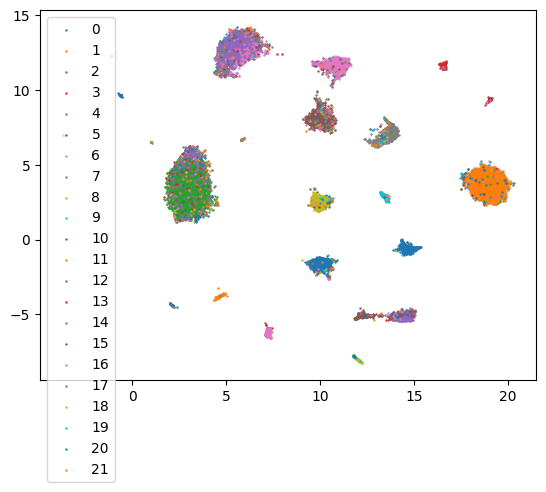

In [15]:
# celltype着色
%matplotlib inline
labels = np.unique(label)  # 获取唯一的标签值
for i in labels:
    plt.scatter(embedding_tsne[label == i, 0], embedding_tsne[label == i, 1], s=0.5, label=str(i))
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import silhouette_score,silhouette_samples, accuracy_score, f1_score
import pandas as pd
import numpy as np
## 轮廓系数
sil_type = silhouette_samples(np.array(embedding_tsne), label)
sil_omic = silhouette_samples(np.array(embedding_tsne), metadata)
sil_f1 = (
            2
            * (1 - (sil_omic + 1) / 2)
            * (sil_type + 1)
            / 2
            / (1 - (sil_omic + 1) / 2 + (sil_type + 1) / 2)
        )
sil_type.mean(), sil_omic.mean(), sil_f1.mean()

(0.44511417, 0.0019665484, 0.56159174)

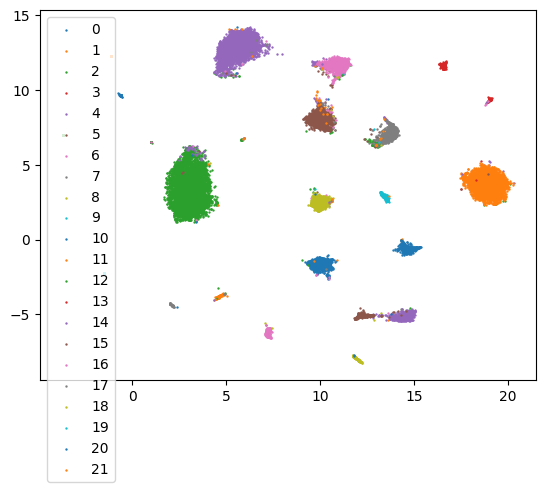

In [17]:
# pre着色
%matplotlib inline
pres = np.unique(pre)  # 获取唯一的标签值
for i in pres:
    plt.scatter(embedding_tsne[pre == i, 0], embedding_tsne[pre == i, 1], s=0.5, label=str(i))
plt.legend()
plt.show()

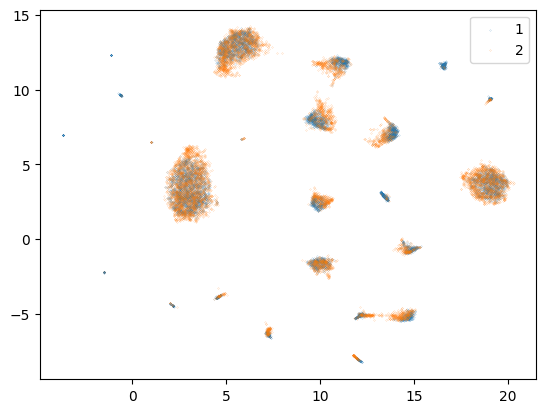

In [18]:
# tech着色
%matplotlib inline
metadatas = np.unique(metadata)  # 获取唯一的标签值
for i in metadatas:
    plt.scatter(embedding_tsne[metadata == i, 0], embedding_tsne[metadata == i, 1], s=0.01, label=str(i))
plt.legend()
plt.show()

In [ ]:
#                 best_val = result[1]
#                 best_query = result[3]
                
#                 os.makedirs(args.model_dir, exist_ok=True)
#                 os.makedirs('../resultscolon/', exist_ok=True)
                
#                 if args.save_model:
#                     torch.save(model.state_dict(), args.model_dir + f'{args.dataset}-{args.method}.pkl')
                
#                 ### Save results ###
#                 filename = f'../resultscolon/{args.dataset}.csv'
#                 print(f"Saving results to {filename}")
#                 with open(f"{filename}", 'w') as write_obj:
#                     write_obj.write(f"{args.method}," +
#                                     f"epoch: {epoch:02d}," +
#                                     f"Query: {100 * result[3]:.2f}%")
                    
#                 torch.save(z2, '../resultscolon/embedding.pt')
#                 torch.save(p, '../resultscolon/out.pt')
     
# torch.save(split_idx_lst, '../resultscolon/split_idx_lst.pt')
# torch.save(dataset.label, '../resultscolon/label.pt')
# torch.save(dataset.num_celltype, '../resultscolon/num_celltype.pt')
# torch.save(dataset.metadata, '../resultscolon/metadata.pt')
# torch.save(default_args, '../resultscolon/args-0.004-7.pt')

In [20]:
embedding = torch.load('../results/embedding.pt', map_location=torch.device('cpu'))
embedding = embedding[0].detach().numpy()

label = torch.load('../results/label.pt', map_location=torch.device('cpu')) # 原始的类型
label = label.squeeze().numpy() 

out = torch.load('../results/out.pt', map_location=torch.device('cpu')) # 预测的类型
pre = out.argmax(dim=-1, keepdim=True).detach().squeeze().numpy()
pro = out.max(dim=-1, keepdim=True)[0].detach().squeeze().numpy()

metadata = torch.load('../results/metadata.pt', map_location=torch.device('cpu')) # tech
metadata = metadata.squeeze().numpy() 

num_celltype = torch.load('../results/num_celltype.pt', map_location=torch.device('cpu')) # 数字与类型的对应关系
print(num_celltype)

{0: 'Ast', 1: 'Clau', 2: 'E2Rasgrf2', 3: 'E3Rmst', 4: 'E3Rorb', 5: 'E4Il1rapl2', 6: 'E4Thsd7a', 7: 'E5Galnt14', 8: 'E5Parm1', 9: 'E5Sulf1', 10: 'E5Tshz2', 11: 'E6Tle4', 12: 'Endo', 13: 'InN', 14: 'InP', 15: 'InS', 16: 'InV', 17: 'Mic', 18: 'OPC', 19: 'OliI', 20: 'OliM', 21: 'Peri'}


In [21]:
celltype = [num_celltype[i] for i in label]
pre = [num_celltype[i] for i in pre]
umap1 = embedding_tsne[:,0]
umap2 = embedding_tsne[:,1]
metadata = ["scATAC-seq" if i == 2 else "scRNA-seq" for i in metadata]
import pandas as pd
p = {   'UMAP1' : umap1,
        'UMAP2' : umap2,
        'celltype' : celltype,
        'pre' : pre,
        'tech' : metadata,
        'pro' : pro}
p = pd.DataFrame(p)
p.to_csv('../results/data_list.csv', index=False)
p2 = p[p['tech'] == "scATAC-seq"]
p2.to_csv('../results/data2_list.csv', index=False)